# Descripción del proyecto 

## Objetivo

Los clientes de Beta Bank se están yendo, cada mes, poco a poco. Los banqueros descubrieron que es más barato salvar a los clientes existentes que atraer nuevos.

Es necesario predecir si un cliente dejará el banco pronto. Se tienen los datos sobre el comportamiento pasado de los clientes y la terminación de contratos con el banco.

Crea un modelo con el máximo valor F1 posible. Para aprobar la revisión, necesitas un valor F1 de al menos 0.59. Verifica F1 para el conjunto de prueba. 

Además, debes medir la métrica AUC-ROC y compararla con el valor F1.

In [1]:
#Se importan las librerías

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier

In [2]:
#Se carga el dataset con el que se estará desarrollando el modelo

data = pd.read_csv('/datasets/Churn.csv')

pd.options.mode.chained_assignment = None

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [3]:
#Se examina la información del dataset, para conocer la información que se tiene, y de que manera se encuentra la información
#para saber como trabajarla

data.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [4]:
#Se tratan los valores nulos que existen en el dataset

tenure_avg = data['Tenure'].mean()
data['Tenure'] = data['Tenure'].fillna(tenure_avg)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [5]:
#Se remueven las columnas que se considera que no son prescindibles para realizan las predicciones

data = data.drop(columns = ['RowNumber', 'CustomerId', 'Surname'])
data.sample(10)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9041,513,Germany,Female,49,4.99769,171601.27,1,1,0,126223.84,0
9994,800,France,Female,29,2.00000,0.00,2,0,0,167773.55,0
1091,732,France,Male,36,7.00000,126195.81,1,1,1,133172.48,0
611,650,France,Female,27,6.00000,0.00,2,1,0,1002.39,0
2867,559,Spain,Female,27,1.00000,0.00,1,0,1,1050.33,0
284,799,France,Female,22,8.00000,174185.98,2,0,1,192633.85,0
9170,694,France,Male,30,2.00000,0.00,3,0,1,15039.41,0
8881,744,France,Male,29,1.00000,43504.42,1,1,1,119327.75,0
2823,668,Germany,Female,59,5.00000,120170.07,1,0,1,50454.80,0
9432,458,Germany,Female,28,4.99769,171932.26,2,1,1,9578.24,0


Para dar inicio con la elaboración de las predicciones se carga el data que se va a utilizar, se examinan los datos, y la estructura del dataframe, para procesar la información que sea conveniente y poder trabajar con la data sin ningún problema. En este caso visualizamos que se encontraban valores nulos en una columna, Tenure, para la cual fue necesario tratar ese punto, tratando los valores nulos aplicando la media. Así mismo, también se eliminaron las columnas que no se consideraran tan relevantes para el proyecto de predicción como RowNumber, CustomerId, Surname.

## Codificación de los datos

In [6]:
#Se separan los atributos del target

target = data['Exited']
features = data.drop(['Exited'], axis=1)

In [7]:
#Codificación One-Hot

data_ohe = pd.get_dummies(features, drop_first=True, dtype = int)

data_ohe.sample(10)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
9250,713,42,0.00000,109121.71,1,0,1,167873.49,0,1,1
698,746,36,2.00000,0.00,2,1,1,16436.56,0,1,1
9874,720,44,4.99769,0.00,2,1,0,163471.01,0,0,1
843,773,41,5.00000,0.00,1,1,0,28266.90,0,1,0
4352,564,26,7.00000,84006.88,2,0,0,183490.99,0,0,1
204,512,33,3.00000,176666.62,1,1,0,94670.77,0,1,1
9517,543,37,8.00000,140894.06,2,1,1,118059.19,1,0,1
3369,703,33,8.00000,190566.65,1,1,1,79997.14,0,0,0
2348,824,45,3.00000,129209.48,1,0,0,60151.77,0,0,1
4081,721,33,5.00000,0.00,2,0,1,117626.90,0,1,1


## Estandarización

In [8]:
#Se realiza la partición de los datos

features_train, features_valid, target_train, target_valid = train_test_split(data_ohe, target, test_size=0.25, random_state=12345)

print(features_train.shape)
print(features_valid.shape)
print(target_train.shape)
print(target_valid.shape)

(7500, 11)
(2500, 11)
(7500,)
(2500,)


In [9]:
#Escalado de características - Estandarización

numeric = ['CreditScore', 'Age', 'Tenure', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

#Transformar los datos
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])

features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
226,0.442805,-0.841274,1.446176,-1.224577,0.817772,1,1,-1.269750,0,0,0
7756,-0.310897,-0.270730,0.719177,0.641783,-0.896874,1,1,0.960396,0,1,0
2065,-0.259274,-0.556002,1.082676,-1.224577,0.817772,1,0,0.661864,0,0,1
2800,1.217157,1.155631,1.446176,1.290462,0.817772,1,0,-1.039476,0,0,1
7028,0.690598,-1.221637,-0.008661,1.142121,-0.896874,0,0,-0.851729,1,0,1


In [10]:
features_train[numeric].describe().apply(round)

,CreditScore,Age,Tenure,Age,Balance,NumOfProducts,EstimatedSalary
count,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0
mean,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0
min,-3.0,-2.0,-2.0,-2.0,-1.0,-1.0,-2.0
25%,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
50%,0.0,-0.0,-0.0,-0.0,0.0,-1.0,0.0
75%,1.0,0.0,1.0,0.0,1.0,1.0,1.0
max,2.0,5.0,2.0,5.0,3.0,4.0,2.0


In [11]:
features_valid[numeric].describe().apply(round)

,CreditScore,Age,Tenure,Age,Balance,NumOfProducts,EstimatedSalary
count,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0
mean,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0
min,-3.0,-2.0,-2.0,-2.0,-1.0,-1.0,-2.0
25%,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
50%,-0.0,-0.0,-0.0,-0.0,0.0,1.0,-0.0
75%,1.0,0.0,1.0,0.0,1.0,1.0,1.0
max,2.0,5.0,2.0,5.0,3.0,4.0,2.0


In [12]:
features_train.sample(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
9448,-0.703235,-0.365820,1.082676,1.181725,0.817772,1,0,-1.006821,1,0,1
8857,-0.279923,-0.270730,0.355678,-1.224577,0.817772,0,0,-0.269003,0,0,1
3124,1.124235,0.014543,0.355678,1.640375,-0.896874,1,0,-0.574106,0,0,1
95,-1.405315,-0.365820,1.809675,1.603292,-0.896874,0,1,0.363551,0,1,1
6212,0.814494,2.201630,-1.098320,-1.224577,0.817772,1,1,1.084137,0,1,0


## Creación de modelos

### Modelo Logistic Regression

In [13]:
#Definir y ajustar el modelo

model = LogisticRegression(random_state = 12345, solver = 'liblinear', max_iter = 100)
model.fit(features_train, target_train)

LogisticRegression(random_state=12345, solver='liblinear')

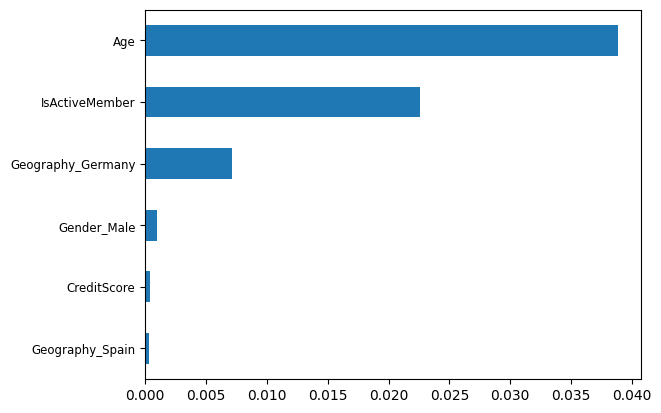

In [14]:
#Visualiar importancia de variables

importancia = permutation_importance(model, features_train, target_train)
data_imp = pd.DataFrame({'importancia':importancia['importances_mean']}, index=features_train.columns)
data_imp = data_imp.sort_values(by='importancia')
data_imp = data_imp.query('importancia > 0')

data_imp.plot(kind = 'barh', legend = False)

plt.yticks(fontsize = 8.5)
plt.show()

In [15]:
#Generar predicciones

predicted_valid = model.predict(features_valid)

#Visualizar la matriz de confusión

print(confusion_matrix(target_valid, predicted_valid))

[[1887   78]
 [ 429  106]]


In [16]:
#Extraer las principales métricas

print(classification_report(target_valid, predicted_valid, digits = 4))

              precision    recall  f1-score   support

           0     0.8148    0.9603    0.8816      1965
           1     0.5761    0.1981    0.2949       535

    accuracy                         0.7972      2500
   macro avg     0.6954    0.5792    0.5882      2500
weighted avg     0.7637    0.7972    0.7560      2500



In [17]:
#Guardar métricas relevantes

acc1 = accuracy_score(target_valid, predicted_valid)
f1_1 = f1_score(target_valid, predicted_valid, average = 'weighted')

print(acc1, f1_1)

0.7972 0.7560125534471784


#### Mejorar el modelo base

##### Balanceo de clases

In [18]:
#Crear y ajustar el modelo

model2 = LogisticRegression(random_state = 12345, solver = 'liblinear', max_iter = 100, class_weight = 'balanced')
model2.fit(features_train, target_train)

LogisticRegression(class_weight='balanced', random_state=12345,
                   solver='liblinear')

In [19]:
#Generar predicciones

predicted_valid = model2.predict(features_valid)

#Extraer las principales métricas

print(classification_report(target_valid, predicted_valid, digits = 4))

              precision    recall  f1-score   support

           0     0.8975    0.7043    0.7893      1965
           1     0.3935    0.7047    0.5050       535

    accuracy                         0.7044      2500
   macro avg     0.6455    0.7045    0.6472      2500
weighted avg     0.7897    0.7044    0.7284      2500



In [20]:
#Se guardan las métricas relevantes

acc2 = accuracy_score(target_valid, predicted_valid)
f1_2 = f1_score(target_valid, predicted_valid, average = 'weighted')

print(acc2, f1_2)

0.7044 0.7284479850938254


##### Ajustar el umbral de clasificación

In [21]:
#Extraer las probabilidades de clasificación (score)

prob_valid = model2.predict_proba(features_valid)
prob_one_valid = prob_valid[:,1]

print(prob_one_valid[:5])

[0.44916532 0.2577057  0.21019617 0.35674009 0.07547822]


##### Curva ROC y AUC-ROC

In [22]:
#Crear una curva ROC

fpr, tpr, thresholds = roc_curve(target_valid, prob_one_valid)

In [23]:
df_roc = pd.DataFrame({"fpr":fpr, "tpr":tpr, "thresholds":thresholds})
df_roc

,fpr,tpr,thresholds
0,0.000000,0.000000,1.979472
1,0.000509,0.000000,0.979472
2,0.000509,0.003738,0.973002
3,0.004580,0.003738,0.944896
4,0.004580,0.018692,0.933359
...,...,...,...
699,0.969975,0.996262,0.105707
700,0.969975,0.998131,0.104305
701,0.983715,0.998131,0.084959
702,0.983715,1.000000,0.084314


<AxesSubplot:xlabel='Tasa Falsos Positivos', ylabel='Tasa Verdaderos Positivos'>

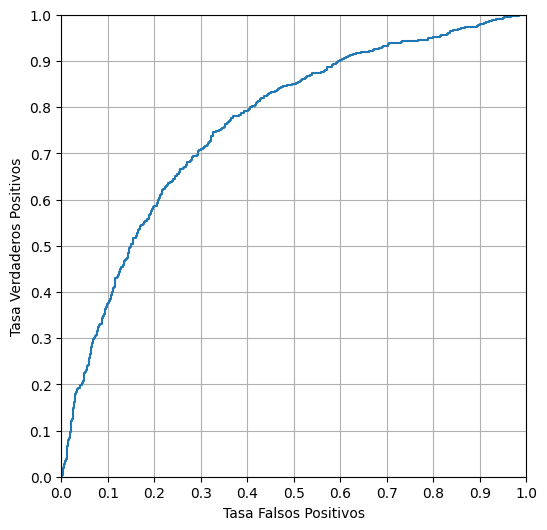

In [24]:
df_roc.plot(
    x='fpr', 
    y='tpr', 
    kind='line', 
    legend=False, 
    xlim=[0,1], 
    ylim=[0,1], 
    xticks=np.array(range(0,110,10))/100,
    yticks=np.array(range(0,110,10))/100,
    xlabel="Tasa Falsos Positivos",
    ylabel="Tasa Verdaderos Positivos",
    figsize=[6,6],
    grid=True
)

In [25]:
#Seleccionar umbral

f1_max = f1_2
u_max = 0.5

for u in thresholds:
    pred=[]
    for y in prob_one_valid:
        if y > u:
            pred.append(1)
        else:
            pred.append(0)
            
    f1_iter = f1_score(target_valid, pred, average='weighted')
    
    if f1_iter > f1_max:
        f1_max = f1_iter
        u_max = u
        
print(f"Score F1 máximo: {f1_max:.4f}")
print(f"Umbral: {u_max:.4f}")

Score F1 máximo: 0.7798
Umbral: 0.6770


In [26]:
#Predecir con umbral óptimo

predic = []
for y in prob_one_valid:
    if y > u_max:
        predic.append(1)
    else:
        predic.append(0)

In [27]:
#Se extraen las principales métricas

print(classification_report(target_valid, predic, digits = 4))

              precision    recall  f1-score   support

           0     0.8501    0.8835    0.8665      1965
           1     0.5000    0.4280    0.4612       535

    accuracy                         0.7860      2500
   macro avg     0.6751    0.6557    0.6639      2500
weighted avg     0.7752    0.7860    0.7798      2500



In [28]:
#Se guardan las métricas relevantes

acc3 = accuracy_score(target_valid, predic)
f1_3 = f1_score(target_valid, predic, average = 'weighted')

print(acc3, f1_3)

0.786 0.7797590721775663


In [29]:
#Resumen de resultados

df_resumen = pd.DataFrame(dict(
    Exactitud = [acc1, acc2, acc3],
    f1_score = [f1_1, f1_2, f1_3]
), index = ['base', 'balanceado', 'balanceo + umbral'])

df_resumen

,Exactitud,f1_score
base,0.7972,0.756013
balanceado,0.7044,0.728448
balanceo + umbral,0.7860,0.779759


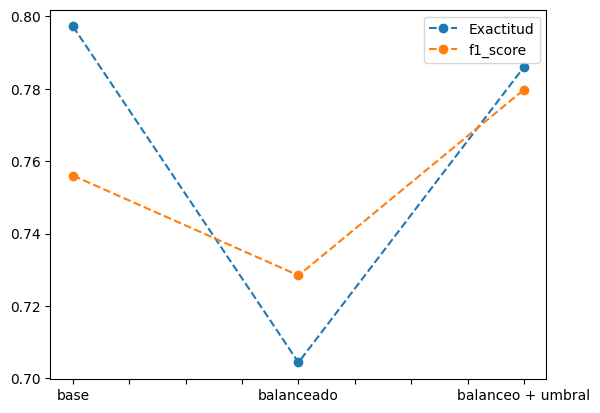

In [30]:
df_resumen.plot(kind='line', marker='o', style='--')
plt.show()

In [31]:
#Estimar el AUC ROC

auc_roc = roc_auc_score(target_valid, prob_one_valid)
print(f"{auc_roc:.1%}")

76.3%


Como podemos observar, las predicciones resultaron con exactitud y score con porcentaje "aceptable", sin embargo no se encontraba tan equilibrado, es decir, en la primer predicción (base), se cuenta con una exactitud más alta que el score, por lo que no es lo ideal. En la segunda predicción (balanceado), bajo tanto su exactitud, como su score, también con diferencia en el equilibrio entre ellos. En la tercer predicción (balanceo + umbral), observamos que subió su exactitud y score, estando más cerca uno del otro, por lo que se encuentra mejor equilibrado, siendo esta la opción ideal.
Así mismo, se compara con el resultado del AUC-ROC, el cual nos arroja un 76.3%, siendo este muy similar al resultado de su exactitud y score, por lo que la tercer predicción del model logistic regression resulta una predicción bastante mejorada.

### Modelo DecisionTreeClassifier

In [32]:
#Definir y ajustar el modelo

mod = DecisionTreeClassifier(random_state=12345)
mod.fit(features_train, target_train)

DecisionTreeClassifier(random_state=12345)

In [33]:
#Generar predicciones

predicted_valid = mod.predict(features_valid)

#Visualizar la matriz de confusión

print(confusion_matrix(target_valid, predicted_valid))

[[1678  287]
 [ 272  263]]


In [34]:
#Extraer las principales métricas

print(classification_report(target_valid, predicted_valid, digits = 4))

              precision    recall  f1-score   support

           0     0.8605    0.8539    0.8572      1965
           1     0.4782    0.4916    0.4848       535

    accuracy                         0.7764      2500
   macro avg     0.6693    0.6728    0.6710      2500
weighted avg     0.7787    0.7764    0.7775      2500



In [35]:
#Guardar métricas relevantes

accu1 = accuracy_score(target_valid, predicted_valid)
f1score_1 = f1_score(target_valid, predicted_valid, average = 'weighted')

print(accu1, f1score_1)

0.7764 0.7775172696293942


#### Mejorar el modelo base

##### Balanceo de clases

In [36]:
#Crear y ajustar el modelo

mod2 = DecisionTreeClassifier(random_state=12345, class_weight = 'balanced')
mod2.fit(features_train, target_train)

#Generar predicciones

predicted_valid = mod2.predict(features_valid)

#Extraer las principales métricas

print(classification_report(target_valid, predicted_valid, digits = 4))

              precision    recall  f1-score   support

           0     0.8600    0.8595    0.8598      1965
           1     0.4851    0.4860    0.4855       535

    accuracy                         0.7796      2500
   macro avg     0.6725    0.6728    0.6726      2500
weighted avg     0.7797    0.7796    0.7797      2500



In [37]:
#Se guardan las métricas relevantes

accu2 = accuracy_score(target_valid, predicted_valid)
f1score_2 = f1_score(target_valid, predicted_valid, average = 'weighted')

print(accu2, f1score_2)

0.7796 0.7796748466418042


##### Ajustar el umbral de clasificación

In [38]:
#Extraer las probabilidades de clasificación (score)

prob_valid = mod2.predict_proba(features_valid)
prob_one_valid = prob_valid[:,1]

print(prob_one_valid[:5])

[1. 0. 0. 1. 0.]


##### Curva ROC Y AUC-ROC

In [39]:
#Crear una curva ROC

fpr, tpr, thresholds = roc_curve(target_valid, prob_one_valid)

df_roc = pd.DataFrame({"fpr":fpr, "tpr":tpr, "thresholds":thresholds})
df_roc

,fpr,tpr,thresholds
0,0.000000,0.000000,2.0
1,0.140458,0.485981,1.0
2,1.000000,1.000000,0.0


<AxesSubplot:xlabel='Tasa Falsos Positivos', ylabel='Tasa Verdaderos Positivos'>

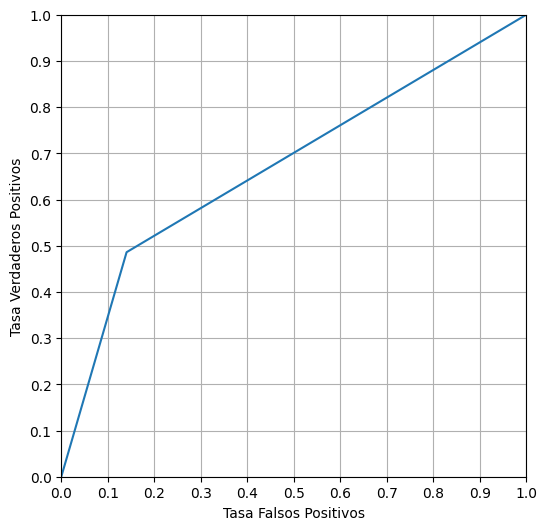

In [40]:
df_roc.plot(
    x='fpr', 
    y='tpr', 
    kind='line', 
    legend=False, 
    xlim=[0,1], 
    ylim=[0,1], 
    xticks=np.array(range(0,110,10))/100,
    yticks=np.array(range(0,110,10))/100,
    xlabel="Tasa Falsos Positivos",
    ylabel="Tasa Verdaderos Positivos",
    figsize=[6,6],
    grid=True
)

In [41]:
#Seleccionar umbral

f1_max = f1score_2
u_max = 0.5

for u in thresholds:
    pred=[]
    for y in prob_one_valid:
        if y > u:
            pred.append(1)
        else:
            pred.append(0)
            
    f1_iter = f1_score(target_valid, pred, average='weighted')
    
    if f1_iter > f1_max:
        f1_max = f1_iter
        u_max = u
        
print(f"Score F1 máximo: {f1_max:.4f}")
print(f"Umbral: {u_max:.4f}")

Score F1 máximo: 0.7797
Umbral: 0.5000


In [42]:
#Predecir con umbral óptimo

predic = []
for y in prob_one_valid:
    if y > u_max:
        predic.append(1)
    else:
        predic.append(0)
        
#Se extraen las principales métricas

print(classification_report(target_valid, predic, digits = 4))

              precision    recall  f1-score   support

           0     0.8600    0.8595    0.8598      1965
           1     0.4851    0.4860    0.4855       535

    accuracy                         0.7796      2500
   macro avg     0.6725    0.6728    0.6726      2500
weighted avg     0.7797    0.7796    0.7797      2500



In [43]:
#Se guardan las métricas relevantes

accu3 = accuracy_score(target_valid, predic)
f1score_3 = f1_score(target_valid, predic, average = 'weighted')

print(accu3, f1score_3)

0.7796 0.7796748466418042


In [44]:
#Resumen de resultados

df_resumen = pd.DataFrame(dict(
    Exactitud = [accu1, accu2, accu3],
    f1_score = [f1score_1, f1score_2, f1score_3]
), index = ['base', 'balanceado', 'balanceo + umbral'])

df_resumen

,Exactitud,f1_score
base,0.7764,0.777517
balanceado,0.7796,0.779675
balanceo + umbral,0.7796,0.779675


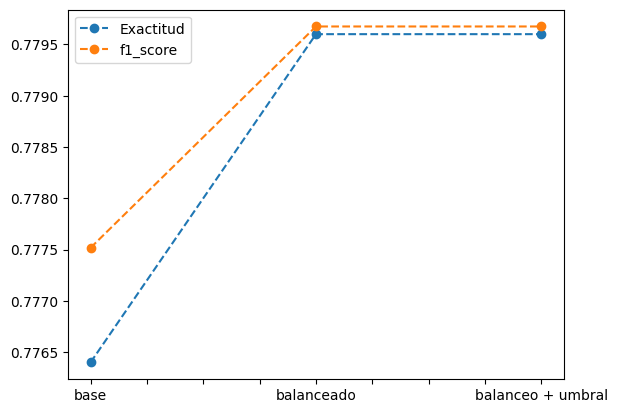

In [45]:
df_resumen.plot(kind='line', marker='o', style='--')
plt.show()

In [46]:
#Estimar el AUC ROC

auc_roc = roc_auc_score(target_valid, prob_one_valid)
print(f"{auc_roc:.1%}")

67.3%


Como podemos observar en las predicciones del modelo DecisionTreeClasifier, de igual manera de realizar tres predicciones, en la primer predicción (base) aunque su exactitud y score, tuvieron resultados "aceptables", el score es mas alto que su exactitud, por lo que no lo hace lo ideal, puesto que no hay un buen equilibrio. En la segunda predicción (balanceado), incrementó tanto su exactitud, como su score, dejandolo más equilibrado, al igual que la tercer predicción (balanceo + umbral), el cual dio como resultado una exactitud y score bastante aceptables y un equilibrio más idóneo.
Sin embargo al observar el porcentaje del AUC-ROC, 67.3% no es tan alto, por lo que el modelo es bueno, pero aún se podría mejorar para que sea mas ideal.

## Conclusiones

Como pudimos observar en los modelos creados y predicciones arrojadas, en ambos modelos se logró mejorar tanto su exactitud y score, y logrando un mejor equilibrio, sin embargo al compararlo con el área bajo la curva (AUC-ROC), podemos visualizar que el modelo de regresión logística resulta más idóneo ya que hay una mejor relación tvp-tfp.